In [1]:
#Imports and set up 
import sklearn
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as ps
import joblib
import warnings
import datetime
import tpot

from re import sub
from decimal import Decimal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn import linear_model
warnings.filterwarnings('ignore')

# Data set up
Seting up data frame for all models

In [2]:
df_salary = pd.read_csv('salaries.csv')
df_yearlystats = pd.read_csv('players_stats_by_season_full_details.csv')

In [3]:
df_yearlystats[df_yearlystats.Stage != 'International'].sort_values(['Player', 'Season']).head()

,League,Season,Stage,Player,Team,GP,MIN,FGM,FGA,3PM,...,birth_date,height,height_cm,weight,weight_kg,nationality,high_school,draft_round,draft_pick,draft_team
184,NBA,1999 - 2000,Regular_Season,A.C. Green,LAL,82,1929.0,173,387,1,...,"Oct 4, 1963",6-9,206.0,220.0,100.0,United States,Benson Polytechnic High School,1.0,23.0,Los Angeles Lakers
253,NBA,1999 - 2000,Playoffs,A.C. Green,LAL,23,429.0,37,90,0,...,"Oct 4, 1963",6-9,206.0,220.0,100.0,United States,Benson Polytechnic High School,1.0,23.0,Los Angeles Lakers
673,NBA,2000 - 2001,Regular_Season,A.C. Green,MIA,82,1411.0,144,324,0,...,"Oct 4, 1963",6-9,206.0,220.0,100.0,United States,Benson Polytechnic High School,1.0,23.0,Los Angeles Lakers
12151,NBA,2010 - 2011,Playoffs,A.J. Price,IND,5,80.0,13,35,7,...,"Oct 7, 1986",6-2,188.0,195.0,88.0,United States,Amityville Memorial High School,2.0,22.0,Indiana Pacers
9346,NBA,2008 - 2009,Regular_Season,Aaron Brooks,HOU,80,1998.1,316,783,113,...,"Jan 14, 1985",6-0,183.0,161.0,73.0,United States,Benjamin Franklin High School,1.0,26.0,Houston Rockets


In [4]:
#prep salary data for join
df_salary.rename(inplace= True, 
                columns={
                    'playerName' : 'Player',
                })
df_salary['Player'] = df_salary['Player'].astype('string')
df_salary['seasonStartYear'] = df_salary['seasonStartYear'].astype('string')
df_salary.head()

,Player,seasonStartYear,salary,inflationAdjSalary
0,Michael Jordan,1996,"$30,140,000","$52,258,566"
1,Horace Grant,1996,"$14,857,000","$25,759,971"
2,Reggie Miller,1996,"$11,250,000","$19,505,934"
3,Shaquille O'Neal,1996,"$10,714,000","$18,576,585"
4,Gary Payton,1996,"$10,212,000","$17,706,187"


In [5]:
#prep stats data for join 
df_yearlystats['Season'] = df_yearlystats['Season'].str[0:4]
df_yearlystats['Season'] = df_yearlystats['Season'].astype('string')
df_yearlystats.rename(inplace=True, columns={
    'Season' : 'seasonStartYear',
})
df_yearlystats.head()

,League,seasonStartYear,Stage,Player,Team,GP,MIN,FGM,FGA,3PM,...,birth_date,height,height_cm,weight,weight_kg,nationality,high_school,draft_round,draft_pick,draft_team
0,NBA,1999,Regular_Season,Shaquille O'Neal,LAL,79,3163.0,956,1665,0,...,"Mar 6, 1972",7-1,216.0,325.0,147.0,United States,Robert G. Cole High School,1.0,1.0,Orlando Magic
1,NBA,1999,Regular_Season,Vince Carter,TOR,82,3126.0,788,1696,95,...,"Jan 26, 1977",6-6,198.0,220.0,100.0,United States,Mainland High School,1.0,5.0,Golden State Warriors
2,NBA,1999,Regular_Season,Karl Malone,UTA,82,2947.0,752,1476,2,...,"Jul 24, 1963",6-9,206.0,265.0,120.0,United States,Summerfield High School,1.0,13.0,Utah Jazz
3,NBA,1999,Regular_Season,Allen Iverson,PHI,70,2853.0,729,1733,89,...,"Jun 7, 1975",6-0,183.0,165.0,75.0,United States,Bethel High School,1.0,1.0,Philadelphia Sixers
4,NBA,1999,Regular_Season,Gary Payton,SEA,82,3425.0,747,1666,177,...,"Jul 23, 1968",6-4,193.0,180.0,82.0,United States,Skyline High School,1.0,2.0,Seattle SuperSonics


In [6]:
#Get aggragtes of regualr and post season 
grouped = df_yearlystats.groupby(['seasonStartYear', 'Player'])
df_grouping = grouped.sum()

#join data frames
df_midstep = pd.merge(df_yearlystats, df_grouping, how='inner', on = ['seasonStartYear', 'Player'], suffixes=['_part', '_total'])
df = pd.merge(df_salary, df_midstep, how='inner', on = ['seasonStartYear', 'Player'])
df.head()

,Player,seasonStartYear,salary,inflationAdjSalary,League,Stage,Team,GP_part,MIN_part,FGM_part,...,AST_total,STL_total,BLK_total,PTS_total,birth_year_total,height_cm_total,weight_total,weight_kg_total,draft_round_total,draft_pick_total
0,Shaquille O'Neal,1999,"$17,142,858","$28,024,343",NBA,Regular_Season,LAL,79,3163.0,956,...,370,49,294,3051,3944.0,432.0,650.0,294.0,2.0,2.0
1,Shaquille O'Neal,1999,"$17,142,858","$28,024,343",NBA,Playoffs,LAL,23,1000.0,286,...,370,49,294,3051,3944.0,432.0,650.0,294.0,2.0,2.0
2,Kevin Garnett,1999,"$16,806,300","$27,474,154",NBA,Regular_Season,MIN,81,3243.0,759,...,436,125,129,1932,3952.0,422.0,480.0,218.0,2.0,10.0
3,Kevin Garnett,1999,"$16,806,300","$27,474,154",NBA,Playoffs,MIN,4,171.0,30,...,436,125,129,1932,3952.0,422.0,480.0,218.0,2.0,10.0
4,Alonzo Mourning,1999,"$15,004,800","$24,529,146",NBA,Regular_Season,MIA,79,2748.0,652,...,137,42,327,1934,3940.0,416.0,480.0,218.0,2.0,4.0


In [7]:
#drop extra columns and filtering
df = df[df.Stage == 'Regular_Season']
df['salary'] = df['salary'].apply(lambda x: Decimal(sub(r'[^\d.]', '',  x))).astype('int')

df['seasonStartYear'] = df['seasonStartYear'].astype('int')
df = df[['seasonStartYear', 'Player', 'GP_total', 'MIN_total', 'FGM_total', 'FGA_total', '3PM_total', 
         '3PA_total', 'FTM_total', 'FTA_total',  'TOV_total', 'PF_total', 'ORB_total', 'DRB_total', 'REB_total',
         'AST_total', 'STL_total', 'BLK_total', 'PTS_total', 'birth_year_part', 'height_cm_part', 'weight_part', 'salary']]

df.head()

,seasonStartYear,Player,GP_total,MIN_total,FGM_total,FGA_total,3PM_total,3PA_total,FTM_total,FTA_total,...,DRB_total,REB_total,AST_total,STL_total,BLK_total,PTS_total,birth_year_part,height_cm_part,weight_part,salary
0,1999,Shaquille O'Neal,102,4163.0,1242,2170,0,1,567,1120,...,978,1433,370,49,294,3051,1972.0,216.0,325.0,17142858
2,1999,Kevin Garnett,85,3414.0,789,1604,32,84,322,420,...,763,999,436,125,129,1932,1976.0,211.0,240.0,16806300
4,1999,Alonzo Mourning,89,3124.0,728,1341,0,5,478,678,...,607,853,137,42,327,1934,1970.0,208.0,240.0,15004800
6,1999,Patrick Ewing,76,2496.0,432,945,0,2,269,372,...,568,737,64,52,104,1133,1962.0,213.0,240.0,15000000
8,1999,Juwan Howard,82,2909.0,509,1108,0,7,202,275,...,338,470,247,67,21,1220,1973.0,206.0,240.0,15000000


In [52]:
#add extra fields 
df_averages = df.copy()
df_averages['PPG'] = (df_averages['PTS_total']/df_averages['GP_total'])
#MPG = minutes per game
df_averages['MPG'] = (df_averages['MIN_total']/df_averages['GP_total'])
df_averages['APG'] = (df_averages['AST_total']/df_averages['GP_total'])
df_averages['RPG'] = (df_averages['REB_total']/df_averages['GP_total'])
df_averages['SPG'] = (df_averages['STL_total']/df_averages['GP_total'])
df_averages['BPG'] = (df_averages['BLK_total']/df_averages['GP_total'])
df_averages = df_averages[['salary', 'PPG', 'MPG', 'APG', 'RPG', 'SPG', 'BPG', 'MIN_total', 'seasonStartYear','birth_year_part']]
df_averages.head()

,salary,PPG,MPG,APG,RPG,SPG,BPG,MIN_total,seasonStartYear,birth_year_part
0,17142858,29.911765,40.813725,3.627451,14.049020,0.480392,2.882353,4163.0,1999,1972.0
2,16806300,22.729412,40.164706,5.129412,11.752941,1.470588,1.517647,3414.0,1999,1976.0
4,15004800,21.730337,35.101124,1.539326,9.584270,0.471910,3.674157,3124.0,1999,1970.0
6,15000000,14.907895,32.842105,0.842105,9.697368,0.684211,1.368421,2496.0,1999,1962.0
8,15000000,14.878049,35.475610,3.012195,5.731707,0.817073,0.256098,2909.0,1999,1973.0


In [9]:
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
seasonStartYear,0,0.0
Player,0,0.0
GP_total,0,0.0
MIN_total,0,0.0
FGM_total,0,0.0
FGA_total,0,0.0
3PM_total,0,0.0
3PA_total,0,0.0
FTM_total,0,0.0
FTA_total,0,0.0


Text(0, 0.5, 'correlation')

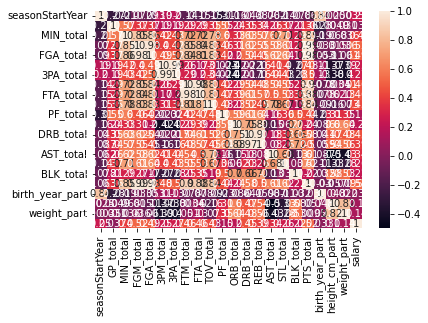

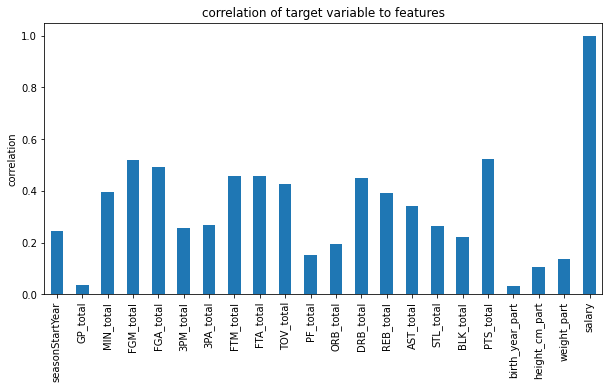

In [10]:
#heatmap and stats 
sns.heatmap(df.corr(),annot=True)

plt.figure(figsize=(10,5))
ax = df.corr()['salary'].plot(kind='bar',title='correlation of target variable to features')
ax.set_ylabel('correlation')

Text(0, 0.5, 'correlation')

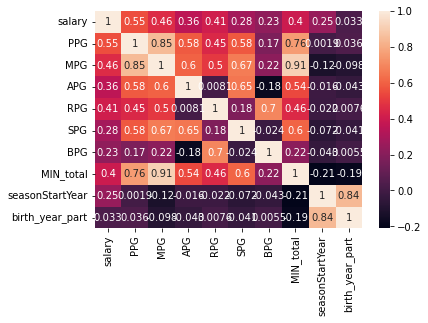

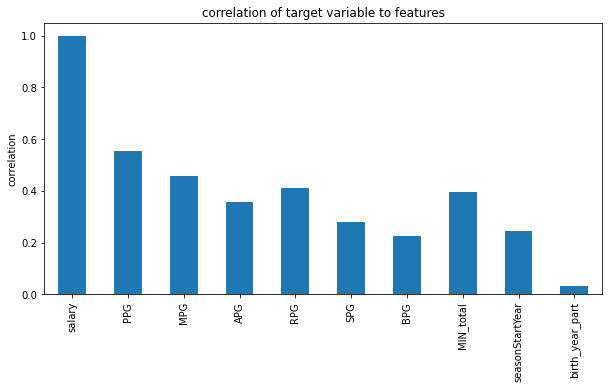

In [11]:
sns.heatmap(df_averages.corr(),annot=True)

plt.figure(figsize=(10,5))
ax = df_averages.corr()['salary'].plot(kind='bar',title='correlation of target variable to features')
ax.set_ylabel('correlation')

In [12]:
df_averages.mean()

salary             6.248547e+06
PPG                1.134039e+01
MPG                2.650713e+01
APG                2.462257e+00
RPG                4.724377e+00
SPG                8.372416e-01
BPG                5.425468e-01
MIN_total          2.117000e+03
seasonStartYear    2.009497e+03
birth_year_part    1.982769e+03
dtype: float64

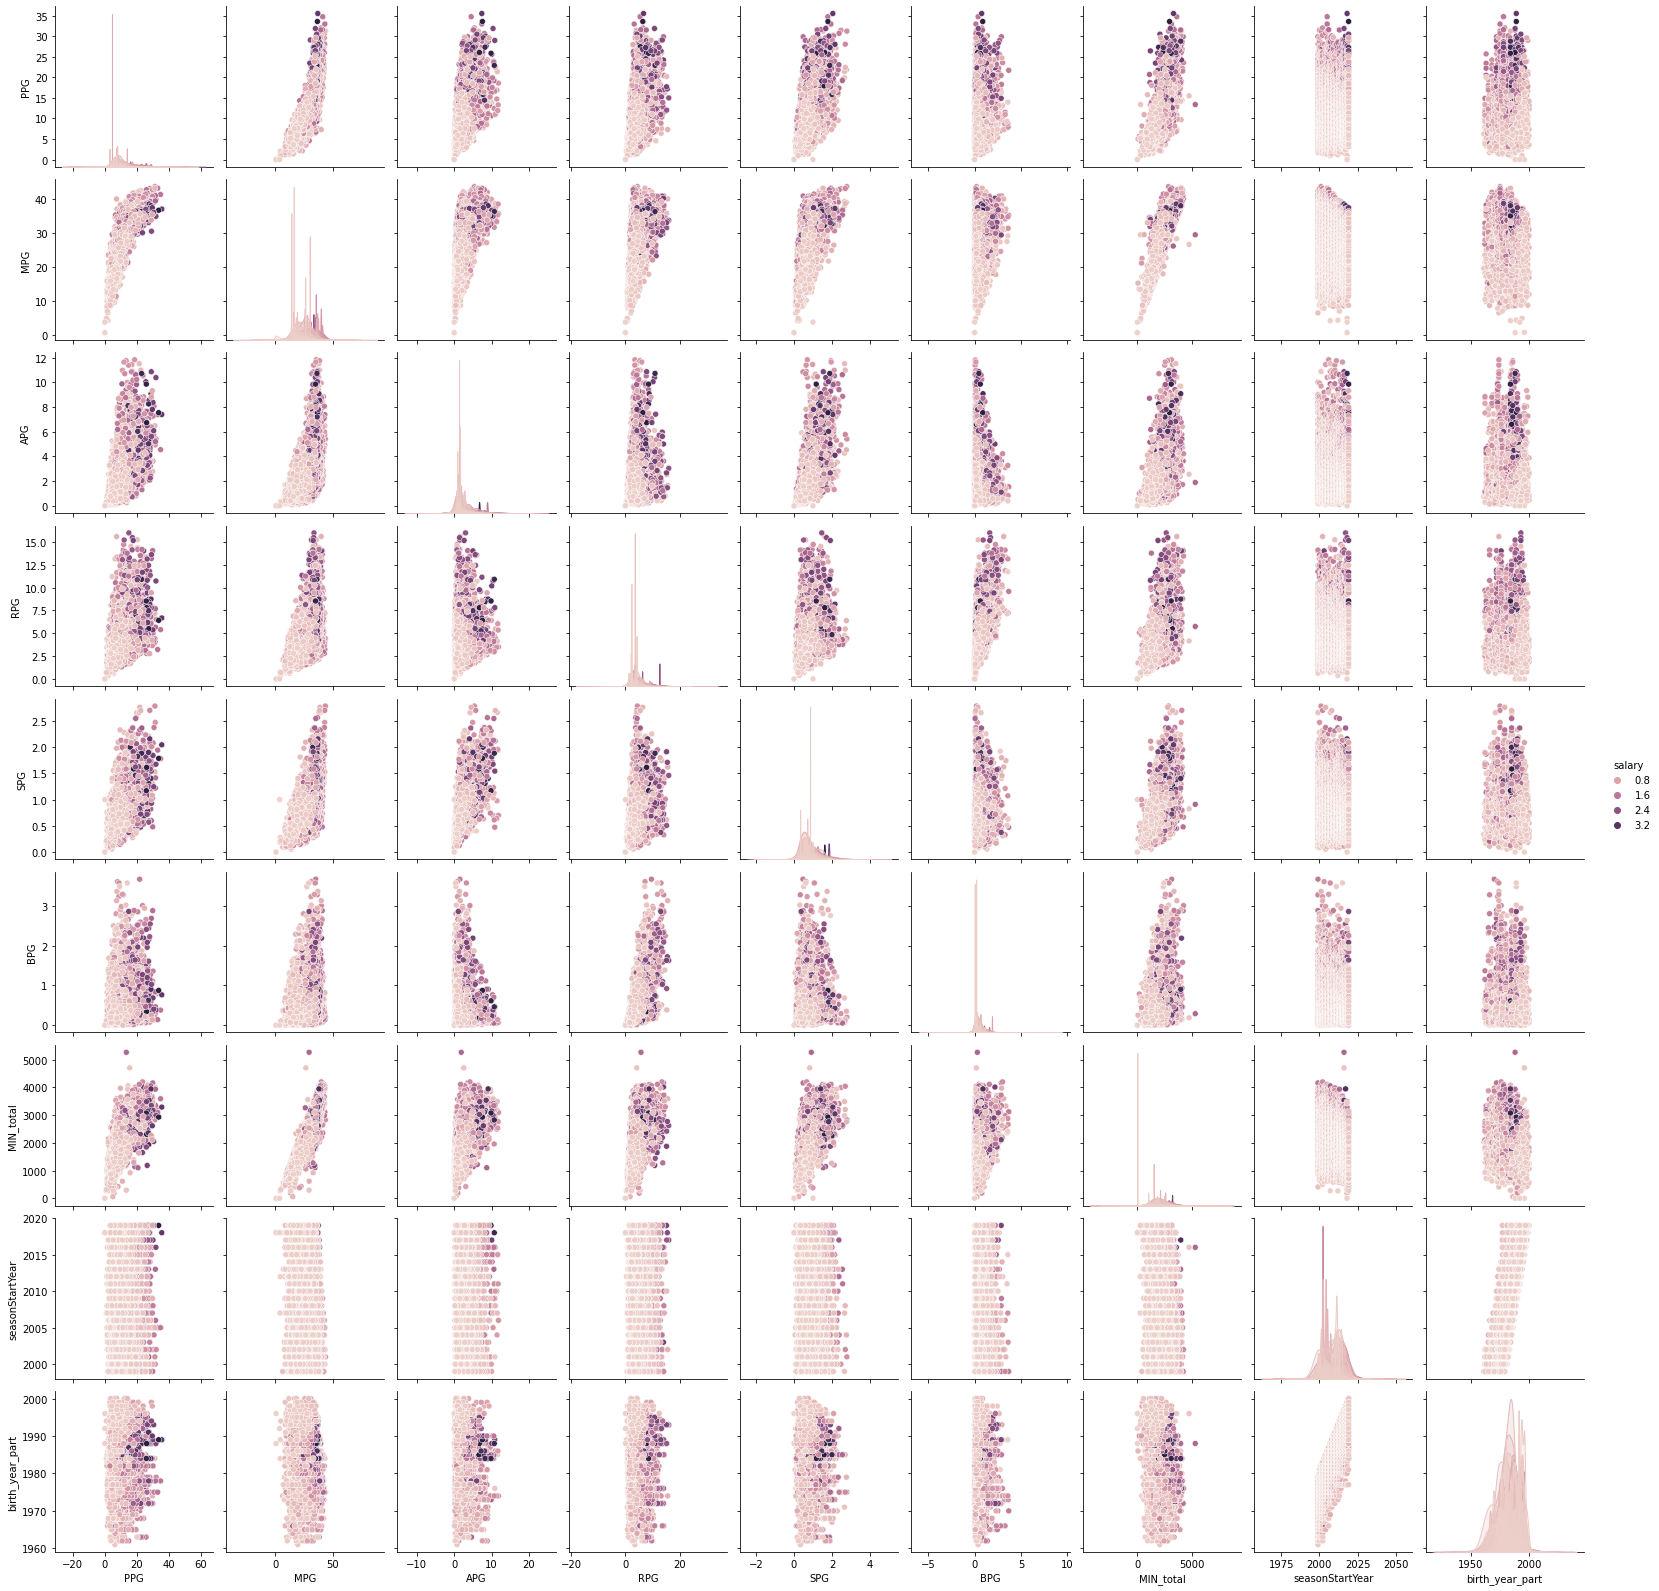

In [13]:
#takes a long time to run 
sns.pairplot(df_averages, hue="salary")

In [14]:
df_averages['salary'].describe()

count    4.394000e+03
mean     6.248547e+06
std      6.072756e+06
min      7.725000e+04
25%      1.959960e+06
50%      4.000000e+06
75%      8.597948e+06
max      3.850648e+07
Name: salary, dtype: float64

# Model 1
SVC for salary ranges<br> Includes iterative devolpment process

In [15]:
X = df.drop(columns=['salary', 'Player'],axis=1) 
y = df.salary

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

In [16]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#lr = LogisticRegression(random_state=40)
#lr.fit(X_train, y_train)
#train_accuracy = lr.score(X_train, y_train)
#test_accuracy = lr.score(X_test, y_test)
#print('Accuracy in Train set   : {:.2f}'.format(train_accuracy), 
#      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

In [17]:
df_buckets = df_averages.copy()

In [18]:
bins = [0,1000000,2000000,6000000, 10000000, 15000000, 400000000]
labels = []
for index, i in enumerate(bins):
    if index +2>= len(bins):
        labels.append(f'${i}+')
        break
    labels.append(f'${i}-${bins[index+1]}')
   
labels

['$0-$1000000',
 '$1000000-$2000000',
 '$2000000-$6000000',
 '$6000000-$10000000',
 '$10000000-$15000000',
 '$15000000+']

In [19]:
#df_buckets = df_buckets[['seasonStartYear','FGM_total',  '3PM_total', 
 #         'FTM_total', 'TOV_total', 'REB_total',
  #      'AST_total', 'STL_total', 'BLK_total',  'birth_year_part', 'salary']]

In [20]:
df_buckets['salary_range']= pd.cut(x=df_buckets['salary'], bins=bins, labels=labels)
print(df_buckets[['salary_range','salary']].head(5))

          salary_range    salary
0           $15000000+  17142858
2           $15000000+  16806300
4           $15000000+  15004800
6  $10000000-$15000000  15000000
8  $10000000-$15000000  15000000


In [21]:
X = df_buckets.drop(columns=['salary', 'salary_range' ],axis=1) 
y = df_buckets.salary_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=40)

Text(0.5, 1.0, 'Salary range')

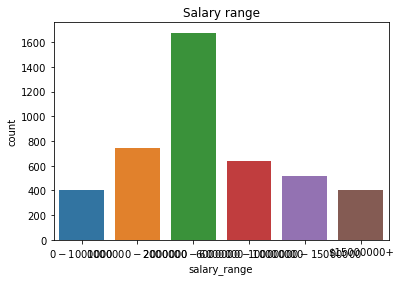

In [22]:
sns.countplot(data=df_buckets, x="salary_range").set_title("Salary range")

In [23]:
lr = LogisticRegression(random_state=40)

lr.fit(X_train, y_train)
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 0.43
Accuracy in Test  set   : 0.40


In [33]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix as cm
from sklearn.inspection import permutation_importance 

In [25]:
clf = make_pipeline(StandardScaler(), SVC(gamma=0.9, degree=5,
                                          class_weight='balanced', probability=True, random_state=22))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(class_weight='balanced', degree=5, gamma=0.9,
                     probability=True, random_state=22))])

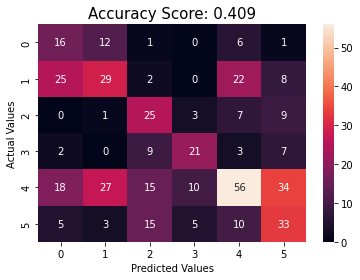

In [26]:
predictions = clf.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

Decrease number of buckets


Text(0.5, 1.0, 'Salary range')

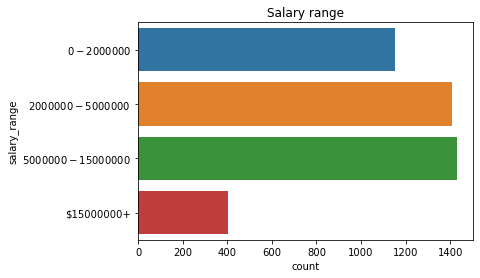

In [54]:
#less buckets
bins = [0,2000000,5000000, 15000000, 400000000]
labels = []
for index, i in enumerate(bins):
    if index +2>= len(bins):
        labels.append(f'${i}+')
        break
    labels.append(f'${i}-${bins[index+1]}')
   
df_buckets['salary_range']= pd.cut(x=df_buckets['salary'], bins=bins, labels=labels)
X = df_buckets.drop(columns=['salary', 'salary_range' ],axis=1) 
y = df_buckets.salary_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=40)

sns.countplot(data=df_buckets, y="salary_range").set_title("Salary range")

In [28]:
labels

['$0-$2000000', '$2000000-$5000000', '$5000000-$15000000', '$15000000+']

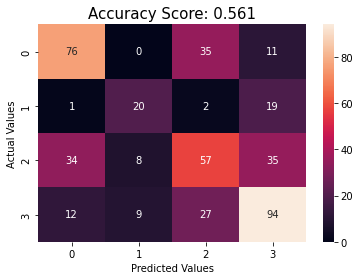

In [29]:
clf = make_pipeline(StandardScaler(), SVC(gamma=0.85, degree=3,
                                          class_weight='balanced', probability=True, random_state=22))
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

<AxesSubplot:>

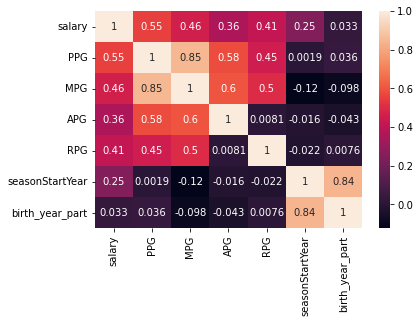

In [30]:
#'salary', 'PPG', 'MPG', 'APG', 'RPG', 'SPG', 'BPG', 'MIN_total', 'seasonStartYear','birth_year_part'
df_buckets = df_averages[['salary', 'PPG', 'MPG', 'APG', 'RPG', 'seasonStartYear','birth_year_part' ]]
sns.heatmap(df_buckets.corr(),annot=True)

# Final version of model 1

In [53]:
df_buckets.head()

,salary,PPG,MPG,APG,RPG,seasonStartYear,birth_year_part,salary_range
0,17142858,29.911765,40.813725,3.627451,14.049020,1999,1972.0,$15000000+
2,16806300,22.729412,40.164706,5.129412,11.752941,1999,1976.0,$15000000+
4,15004800,21.730337,35.101124,1.539326,9.584270,1999,1970.0,$15000000+
6,15000000,14.907895,32.842105,0.842105,9.697368,1999,1962.0,$5000000-$15000000
8,15000000,14.878049,35.475610,3.012195,5.731707,1999,1973.0,$5000000-$15000000


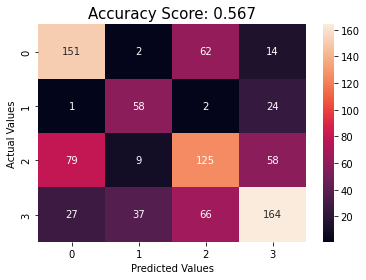

In [35]:
df_buckets['salary_range']= pd.cut(x=df_buckets['salary'], bins=bins, labels=labels)
X = df_buckets.drop(columns=['salary', 'salary_range' ],axis=1) 
y = df_buckets.salary_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)
clf = make_pipeline(StandardScaler(), SVC(gamma=1.5, degree=3,
                                           class_weight='balanced', probability=True, random_state=22))
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

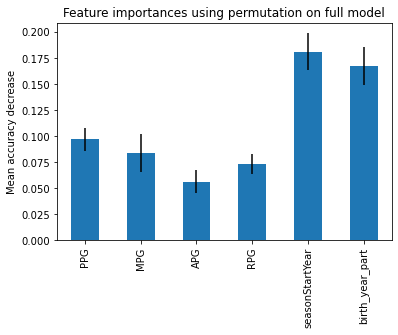

In [36]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
feature_names = ['PPG', 'MPG', 'APG', 'RPG', 'seasonStartYear', 'birth_year_part']
svm_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
svm_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()

# Model 2
The SGD Model

In [37]:
df_model2 = df_averages.copy()

In [38]:
df_model2 = df_model2[['salary', 'PPG', 'MPG', 'APG', 'RPG', 'seasonStartYear','birth_year_part' ]]

In [39]:
from sklearn.neural_network import MLPClassifier


In [40]:
bins = [0,2000000,5000000, 15000000, 400000000]
labels = []
for index, i in enumerate(bins):
    if index +2>= len(bins):
        labels.append(f'${i}+')
        break
    labels.append(f'${i}-${bins[index+1]}')
   
labels

['$0-$2000000', '$2000000-$5000000', '$5000000-$15000000', '$15000000+']

In [41]:
df_model2['salary_range']= pd.cut(x=df_model2['salary'], bins=bins, labels=labels)
print(df_model2[['salary_range','salary']].head(5))

         salary_range    salary
0          $15000000+  17142858
2          $15000000+  16806300
4          $15000000+  15004800
6  $5000000-$15000000  15000000
8  $5000000-$15000000  15000000


In [42]:
X = df_model2.drop(columns=['salary', 'salary_range' ],axis=1) 
y = df_model2.salary_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 40)

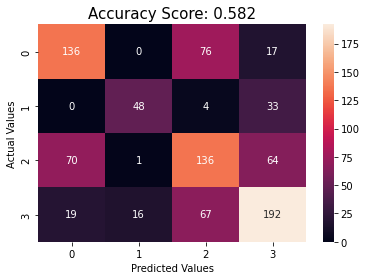

In [43]:
clf = make_pipeline(StandardScaler(), MLPClassifier(solver='sgd', alpha=0.7,                     
                     hidden_layer_sizes=(20, 40), random_state = 21, max_iter=300))
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm2 = cm(y_test, predictions)
sns.heatmap(cm2, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

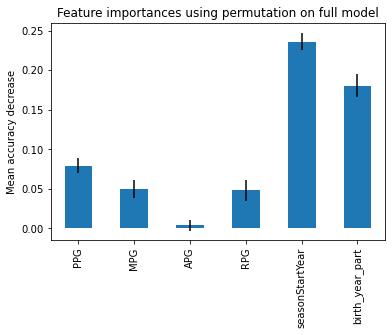

In [44]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
feature_names = ['PPG', 'MPG', 'APG', 'RPG', 'seasonStartYear', 'birth_year_part']
mlp_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
mlp_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()

# Model 3
Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
df_model3 = df_averages.copy()
df_model3 = df_model3[['salary', 'PPG', 'MPG', 'APG', 'RPG', 'seasonStartYear','birth_year_part' ]]
bins = [0,2000000,5000000, 15000000, 400000000]
labels = []
for index, i in enumerate(bins):
    if index +2>= len(bins):
        labels.append(f'${i}+')
        break
    labels.append(f'${i}-${bins[index+1]}')

In [47]:
df_model3['salary_range']= pd.cut(x=df_model3['salary'], bins=bins, labels=labels)
X = df_model3.drop(columns=['salary', 'salary_range' ],axis=1) 
y = df_model3.salary_range

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 40)

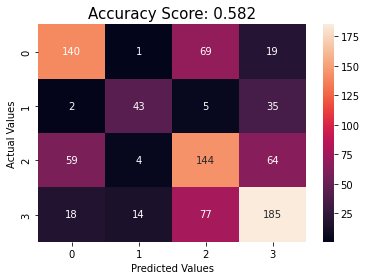

In [48]:
clf = make_pipeline(StandardScaler(), 
                    RandomForestClassifier(max_depth=15, n_estimators=110, random_state = 0))
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm3 = cm(y_test, predictions)
sns.heatmap(cm3, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

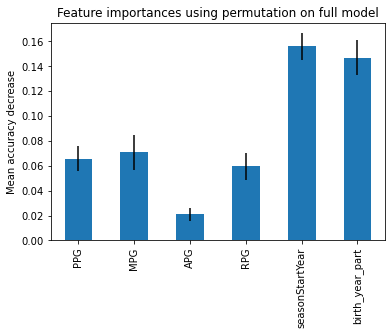

In [49]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
feature_names = ['PPG', 'MPG', 'APG', 'RPG', 'seasonStartYear', 'birth_year_part']
forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()

In [50]:
clf.predict_proba(X_test)

array([[4.81048590e-01, 3.37337438e-04, 3.99269368e-01, 1.19344705e-01],
       [1.66397488e-01, 2.64147825e-02, 3.72490238e-01, 4.34697491e-01],
       [6.32485402e-01, 0.00000000e+00, 2.99052937e-01, 6.84616610e-02],
       ...,
       [1.39219334e-01, 9.09090909e-04, 4.71840901e-01, 3.88030674e-01],
       [4.77429262e-01, 1.17395550e-02, 3.54999391e-01, 1.55831791e-01],
       [2.56024891e-01, 5.45454545e-04, 2.16873928e-01, 5.26555726e-01]])

In [61]:
with open('model-v1.joblib', 'wb') as f:
    joblib.dump(clf,f)

In [64]:
df_model3.describe()

,salary,PPG,MPG,APG,RPG,seasonStartYear,birth_year_part
count,4.394000e+03,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000,4394.000000
mean,6.248547e+06,11.340385,26.507132,2.462257,4.724377,2009.497041,1982.768548
std,6.072756e+06,5.910161,7.715206,1.971759,2.531916,6.176375,7.699477
min,7.725000e+04,0.000000,0.700000,0.000000,0.000000,1999.000000,1961.000000
25%,1.959960e+06,6.833904,20.419308,1.049383,2.869849,2004.000000,1977.000000
50%,4.000000e+06,10.083381,26.766122,1.843953,4.139757,2010.000000,1983.000000
75%,8.597948e+06,14.616296,32.872493,3.245876,6.041118,2015.000000,1989.000000
max,3.850648e+07,35.573034,43.553846,11.839080,15.987179,2019.000000,2000.000000
